<a href="https://colab.research.google.com/github/hemanths03/CS6910_Assignment_2/blob/main/Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing WandB

In [26]:
#Install WandB
!pip install wandb

#Importing the Required Libraries

In [27]:
#Importing some Required Libraries
import wandb
import cv2 , numpy as np
from wandb.keras import WandbCallback
from tensorflow import keras
import random
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.notebook import tqdm
import tensorflow as tf
from wandb.keras import WandbCallback

#Importing Regularizers
from keras import regularizers

#For Data generation
from keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img

#Import the required models
from tensorflow.keras.models import Sequential, Model, load_model

#Import the required layers
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,AveragePooling2D,Dropout,BatchNormalization,Activation

#Import some other Libraries
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.optimizers import Adadelta,Adam

#Importing the activation functions
from tensorflow.keras.activations import relu,softmax

#Importing initializers
from tensorflow.keras.initializers import he_normal,glorot_normal,random_normal,glorot_uniform

#Importing losses
from tensorflow.keras.losses import categorical_crossentropy

#Importing classbacks
from tensorflow.keras.callbacks import EarlyStopping

#Importing backend as k
from tensorflow.keras import backend as K

#WandB Login

In [28]:
!wandb login

wandb: Currently logged in as: cs21m027_cs21m011 (use `wandb login --relogin` to force relogin)


#Get the Dataset

In [20]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

--2022-03-30 11:31:19--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip.1’

nature_12K.zip.1     39%[======>             ]   1.39G   126MB/s    eta 17s    ^C


#Unzip the Dataset

In [21]:
!unzip 'nature_12K.zip'

Archive:  nature_12K.zip
replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#Load train and test path

In [29]:
train = 'inaturalist_12K/train'
test = 'inaturalist_12K/val'

#Declare the Labels

In [30]:
labels = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]

#Function show_images (to display sample images of all classes)

In [31]:
def show_images(train_path , labels):

  train_gen = ImageDataGenerator().flow_from_directory(directory = train_path,color_mode = 'rgb',class_mode = 'categorical')
  paths = train_gen.filepaths
  k = 0
  m = 0
  n = 0
  plot = []
  fig, axes = plt.subplots(2, 5, figsize=(12.5,6))
  classes = train_gen.classes
  for i in range(len(paths)):
    if classes[i] == k:
        ax = axes[m,n]
        img = load_img(paths[i] ,target_size = (256,256))
        ax.imshow(img)
        ax.set_title("Class: "+str(classes[i])+","+"Label: "+str(labels[classes[i]]))
        #plot.append(wandb.Image(train_images[i],caption= 'Class='+str(train_labels[i])+', Label='+str(desc[train_labels[i]])))
        n=n+1
        k=k+1
        if(n==5):
          m=1
          n=0
        if k==10:
          break
  plt.tight_layout()
  plt.suptitle("Sample Images of All classes")
  plt.show()


Found 9999 images belonging to 10 classes.


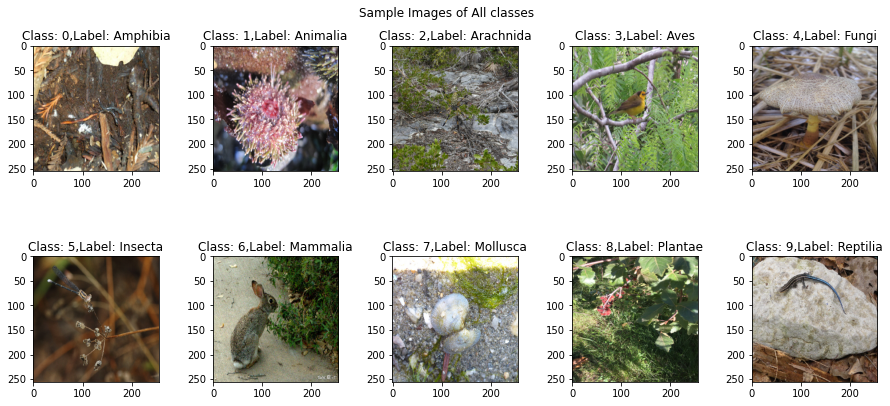

In [32]:
show_images(train , labels)

#Helper function

In [33]:
def helper(model , test_data):
    #predictions
    ypred = model.predict(test_data).argmax(axis=1)
    
    ytrue = test_data.classes

    #Test Accuracy
    test_acc = np.sum(ypred == ytrue)/len(ytrue)
    print("Test accuracy", test_acc)

    #wandb.log( { "test_accuracy": test_acc} )



    #dict1
    maps = test_data.class_indices
    #idx_to_class
    ids = {v:k for k,v in maps.items()}

    random.seed(101)

    #test_image_paths
    paths = test_data.filepaths

    #rnd_idx
    rid = np.random.choice(len(paths),30,replace=False)
    #ix
    var = 1

    plt.figure(figsize=(10,30))

    for i in rid:
      ax = plt.subplot(10,3,var)
      img = load_img(paths[i],target_size=(224,224))
      ax.set_xticks([])
      ax.set_yticks([])
      true_label = ids[ytrue[i]]
      pred_label = ids[ypred[i]]

      ax.set_xlabel("True : " + str(true_label));ax.xaxis.label.set_color('red')
      ax.set_ylabel("Pred : " + str(pred_label));ax.yaxis.label.set_color('green')

      plt.imshow(img)

      var += 1
    plt.show()


#Filter Vizualisation

In [34]:
def filter_visualization():

    model = keras.models.load_model("best_model")

    index = 0

    for i in range(len(model.layers)):
        if "conv" in model.layers[i].name:
            index = i
            break

    conv_layer_1 = model.layers[index]
    filters = conv_layer_1.get_weights()[0]

    #Filter Normalization
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    #Plot the Filters
    n = filters.shape[3]
    rows,cols = int(np.sqrt(n)),int(np.sqrt(n))

    fig = plt.figure(figsize=(rows*1, cols*1))
    plt.axis('off') 
    plt.title("Filter visualisation of first convolutional layer")
    item=1

    for i in range(n):
        cf = filters[:, :, :, i]

        ax = fig.add_subplot(rows, cols, item)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(cf)
        item += 1

    plt.show()
    #plt.savefig('filter_visualise.png')

#Random image filter visualization

In [35]:
def image_filter_visualization(test_data):
    
    paths = test_data.filepaths
    
    id = np.random.choice(len(paths),1,replace=False)
    
    test_image = load_img(paths[int(id)],target_size=(224,224))
    
    model = keras.models.load_model("best_model")
    
    new_model = Model(inputs = model.inputs , outputs = model.layers[0].output)

    plt.imshow(test_image)
    plt.axis('off')
    plt.title('Test image')
    ip_img = img_to_array(test_image)
    ip_img = ip_img.reshape((1,)+ip_img.shape)
    ip_img/=255.0
    

    fmaps = new_model.predict(ip_img)
    num_fmaps = fmaps.shape[3]
    ix = 1
    plt.figure(figsize = (10,6))
    for i in range(num_fmaps):

       ax = plt.subplot(8,8,ix)
       ax.set_xticks([])
       ax.set_yticks([])
       plt.imshow(fmaps[0,:,:,ix-1])
       ix+=1

    plt.suptitle("Feature maps of random Test image of first convolution layer")
    plt.show()

#Guided Backpropagation

In [36]:
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast( x > 0, "float32") * dy
    return tf.nn.relu(x), grad

In [37]:
def process_image(img):
    img = img.copy()
    img -= img.mean()
    img /= (img.std() + K.epsilon())
    img *= 0.25
    
    img = np.clip(img, 0, 255).astype("uint8")
    
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [38]:
def guided_backprop(test_data):
    
    paths = test_data.filepaths
    
    id = np.random.choice(len(paths),1,replace=False)
    
    test_image = load_img(paths[int(id)],target_size=(224,224))
    
    #test_image = load_img(test_data.filepaths[777],target_size=(224,224))
    
    plt.imshow(test_image)
    plt.axis('off')
    plt.title('test image')
    ip_img = img_to_array(test_image)
    ip_img = ip_img.reshape((1,)+ip_img.shape)
    ip_img/=255.0
    
    model = keras.models.load_model('best_model')
    
    activation_index = 0
    all_layers = model.layers
    for i in range(len(all_layers)):
        if "activation" in all_layers[i].name:
            activation_index += 1
            if activation_index == 5:
                activation_index = i
                break
                
    req_shape = model.layers[activation_index].output_shape
    x,y,z = req_shape[1],req_shape[2],req_shape[3]
                
    fig = plt.figure(figsize=(20, 10))
    ix=1
    for p in range(10):
      i,j,k = random.randrange(0, x),random.randrange(0, y),random.randrange(0, z)
        
      neuronNo=random.randint(0,31)
      output_layer1 = [model.layers[activation_index].output[:,j]]

      gb_model=Model(inputs = [model.inputs] , outputs = output_layer1)
      for layer in gb_model.layers: 
        if "activation" in layer.name : layer.activation = guidedRelu

      with tf.GradientTape() as tape:
        inputs = tf.cast(ip_img, tf.float32)
        tape.watch(inputs)
        
        multiplier = np.zeros((1, x, y, z))
        
        multiplier[0][i][j][k] = 1
        outputs = gb_model(inputs)
      grads = tape.gradient(outputs,inputs)[0]
      ax = fig.add_subplot(2,5,ix)
      ax.set_xticks([])
      ax.set_yticks([])

      ax.set_title("Feature map :"+str(k)+"\n Neuron no: ("+str(i)+","+str(j)+")")
      plt.imshow(np.flip(process_image(np.array(grads)),-1))
      ix=ix+1

#Train function Used to train the Model

In [39]:
def train():

    #Initializing WandB
    run = wandb.init()
    config=run.config

    #Setting up the Run name
    name = "fs_" + str(config.filter_size) + "_nf_" + str(config.num_filters) + "_do_" + str(config.dropout)
    run.name = name

    #Setting the target Image size
    target_size = (224,224)

    #set the parameters
    (H , W , D) = (224 , 224 , 3)
    
    epochs = 20

    #Defing the input_shape for the model
    input_shape = (H , W , D)

    train_path = 'inaturalist_12K/train'
    test_path = 'inaturalist_12K/val'

    if config.data_aug == "Yes":
      train_datagen = ImageDataGenerator(rescale = 1./255,
                                        rotation_range = 30,
                                        validation_split = 0.1,
                                        zoom_range = 0.2,
                                        horizontal_flip = True,
                                        shear_range = 12
                                        )

      test_datagen = ImageDataGenerator(rescale = 1./255)
                                        
    else:
      train_datagen = ImageDataGenerator(rescale = 1./255,
                                        validation_split = 0.1)
      

      test_datagen = ImageDataGenerator(rescale = 1./255)

    
    #Getting the training data
    train_set = train_datagen.flow_from_directory(directory = train_path,
                                                  target_size = target_size,
                                                  color_mode = 'rgb',
                                                  batch_size = config.batch_size,
                                                  class_mode = 'categorical',
                                                  seed = 10,
                                                  subset = 'training'
                                                  )
    
    #Getting the validation data
    val_set = train_datagen.flow_from_directory(directory = train_path,
                                                target_size = target_size,
                                                color_mode = 'rgb',
                                                batch_size = config.batch_size,
                                                class_mode = 'categorical',
                                                seed = 10,
                                                subset = 'validation'
                                                )
    
    #Getting the Test data
    test_data = test_datagen.flow_from_directory(directory = test_path,
                                               target_size = target_size,
                                               color_mode = 'rgb',
                                               batch_size = 1,
                                               class_mode = None,
                                               shuffle = False,
                                               seed=10
                                               )
    
    test_data.reset()

  
    # Defining the Model 
    num_filters = [config.num_filters]*5
    filter_size = [(config.filter_size)]*5
    pool_size = [(config.pool_size)]*5
    ac = [config.ac]*5
    
    #Updating num_filters based filter organization
    if config.filter_org == 2:
        for i in range(1, 5) : num_filters[i] = int(num_filters[i - 1] * 2)
    elif config.filter_org == 0.5:
        for i in range(1, 5) : num_filters[i] = int(num_filters[i - 1] / 2)
    
    # Model Defination
    model = Sequential()

    for i in range(5):
        model.add(Conv2D(num_filters[i], filter_size[i], input_shape = (H, W, D)))
        model.add(Activation(ac[i]))
        if config.batch_norm == "Yes" : model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size = pool_size[i]))
        if config.batch_norm == "Yes" : model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(config.num_neurons, activation = 'relu'))
    if config.batch_norm == "Yes" : model.add(BatchNormalization())
    model.add(Dropout(config.dropout))
    model.add(Dense(len(labels), activation = 'softmax'))

    # Model Compilation
    model.compile(
        'adam', 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
        )

    # Model Training
    model.fit(
        train_set,
        steps_per_epoch = ceil((float) (train_set.n) / train_set.batch_size),
        epochs = epochs,
        callbacks = [WandbCallback()],
        validation_data = val_set,
        validation_steps = ceil((float) (val_set.n) / val_set.batch_size)
    )

    #predictions
    ypred = model.predict(test_data).argmax(axis=1)
    
    ytrue = test_data.classes

    #Test Accuracy
    test_acc = np.sum(ypred == ytrue)/len(ytrue)
    print("Test accuracy", test_acc)
    

    #model.save("best_model")

    #helper(model , test_data)
    
    #filter_visualization()
    
    #image_filter_visualization(test_data)
    
    #guided_backprop(test_data)

    run.finish()

#Sweep Configuration 

In [43]:
sweep_config_temp = {
  "name": "Final_sweep_1_b",

  "method": "grid",

  "metric": {
      "name": "accuracy",
      "goal": "maximize"  
    },
  "parameters": {
        "filter_size" : {
            "values" : [3 , 5]
        },
        "pool_size" : {
            "values" : [2]
        },
        "ac" : {
            "values" : ["relu"]
        },
        "num_filters" : {
            "values" : [32 , 64]
        },
        "filter_org" : {
            "values" : [0.5 , 1 , 2]
        },
        "data_aug" : {
            "values" : ["Yes" , "No"]
        },
        "dropout" : {
            "values" : [0.2 , 0.3 , 0.5]
        },
        "batch_norm" : {
            "values" : ["Yes" , "No"]
        },
        "weight_decay" : {
            "values" : [0.01]
        },
        "batch_size" : {
            "values" : [64 , 128]
        },
        "num_neurons" : {
            "values" : [64 , 128 , 256]
        }
    }
}

#Setting the sweep id

In [ ]:
sweep_id = wandb.sweep(sweep_config_temp, entity="cs21m027_cs21m011", project="DL_ASG_2_final_Part_A")

#Starting the Sweeps

In [ ]:
wandb.agent(sweep_id, train)